In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

df = pd.read_csv("Social_Media_Advertising.csv")

### Creating Column Day_Duration ###

This new column will be created for turning duration strings into integers

In [17]:
df["Duration_Days"] = df["Duration"].str.extract("(\\d+)").astype(int)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days'],
      dtype='object')

In [18]:
df["Duration_Days"].head()

0    15
1    15
2    15
3    15
4    15
Name: Duration_Days, dtype: int64

### Creating Column Acquisition_Cost_Num ###

This new column will be created for turning Acquisiton strings into floats

In [19]:
df["Acquisition_Cost_Num"] = df["Acquisition_Cost"].replace("[$,]", "", regex=True).astype(float)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num'],
      dtype='object')

In [20]:
df["Acquisition_Cost_Num"].head()

0    500.0
1    500.0
2    500.0
3    500.0
4    500.0
Name: Acquisition_Cost_Num, dtype: float64

### Creating Column Season ###

This new column will be created for turning Dates into Seasons

In [21]:
df["Date"] = pd.to_datetime(df["Date"])

df["Month"] = df["Date"].dt.month

df[["Date","Month"]].head()

,Date,Month
0,2022-02-25,2
1,2022-05-12,5
2,2022-06-19,6
3,2022-09-08,9
4,2022-08-24,8


In [22]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["Season"] = df["Month"].apply(get_season)

In [23]:
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num', 'Month', 'Season'],
      dtype='object')

In [24]:
df[["Date","Month", "Season"]].head(4)

,Date,Month,Season
0,2022-02-25,2,Winter
1,2022-05-12,5,Spring
2,2022-06-19,6,Summer
3,2022-09-08,9,Fall


In [25]:
hybrid_df = df.copy()

In [26]:
hybrid_df["CTR"] = hybrid_df["Clicks"] / hybrid_df["Impressions"]
hybrid_df["Cost_per_Click"] = hybrid_df["Acquisition_Cost_Num"] / hybrid_df["Clicks"].replace(0, 1)


In [27]:
conv_df = [
    "Duration_Days",
    "Acquisition_Cost_Num",
    "Clicks",
    "Impressions",
    "Engagement_Score",
    "CTR",
    "Cost_per_Click",
    "Channel_Used",
    "Target_Audience",
    "Location",
    "Language",
    "Campaign_Goal",
    "Customer_Segment",
    "Season"
]

conv_df = hybrid_df[conv_df + ["Conversion_Rate"]]

In [28]:
conv_encoded = pd.get_dummies(
    conv_df,
    columns=[
        "Channel_Used",
        "Target_Audience",
        "Location",
        "Language",
        "Campaign_Goal",
        "Customer_Segment",
        "Season"
    ],
    drop_first=True
)


In [29]:
X_conv = conv_encoded.drop("Conversion_Rate", axis=1)
y_conv = conv_encoded["Conversion_Rate"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_conv, y_conv, test_size=0.2, random_state=42
)

In [30]:
conv_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

conv_model.fit(Xc_train, yc_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",300
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [31]:
conv_pred = conv_model.predict(Xc_test)

conv_r2 = r2_score(yc_test, conv_pred)
conv_mae = mean_absolute_error(yc_test, conv_pred)

print("Conversion Model R²:", conv_r2)
print("Conversion Model MAE:", conv_mae)

Conversion Model R²: -0.0006087251822053386
Conversion Model MAE: 0.034880874682709624


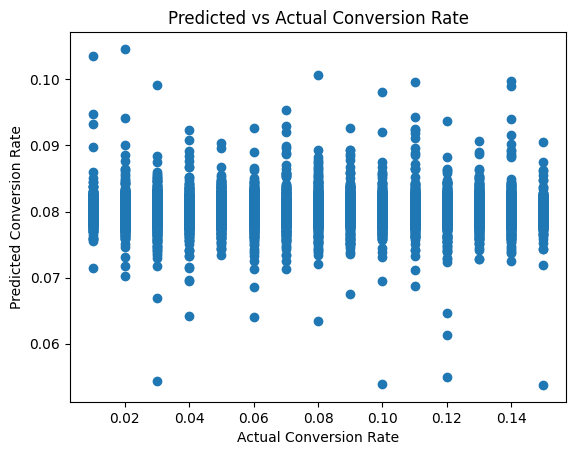

In [32]:
plt.scatter(yc_test, conv_pred)
plt.xlabel("Actual Conversion Rate")
plt.ylabel("Predicted Conversion Rate")
plt.title("Predicted vs Actual Conversion Rate")
plt.show()